# Mod 3 Final Project

## Student Info

- Name: Alex Beat
- Cohort: 100719 pt 
- Instructor: James Irving


## Instructions:

- Open and read the project assignment and guidelines in `MOD_PROJECT_README.ipynb`
- Review the hypothesis testing workflow found in this repo's `README.md` and at the bottom of the `MOD_PROJECT_README.ipynb`
- 3 functions from study group/learn.co lessons have been provided inside `functions.py`
    - `Cohen_d`, `find_outliers_IQR`,`find_outliers_Z`

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-mod-3-project-online-ds-ft-100719/master/Northwind_ERD_updated.png">

# PROJECT

In [1]:
!pip install -U fsds_100719
from fsds_100719.imports import *

import pandas as pd


fsds_1007219  v0.7.6 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


['[i] Pandas .iplot() method activated.']


In [2]:

import scipy.stats as stats
import numpy as np

def Cohen_d(group1, group2, correction = False):
    """Compute Cohen's d
    d = (group1.mean()-group2.mean())/pool_variance.
    pooled_variance= (n1 * var1 + n2 * var2) / (n1 + n2)

    Args:
        group1 (Series or NumPy array): group 1 for calculating d
        group2 (Series or NumPy array): group 2 for calculating d
        correction (bool): Apply equation correction if N<50. Default is False. 
            - Url with small ncorrection equation: 
                - https://www.statisticshowto.datasciencecentral.com/cohens-d/ 
    Returns:
        d (float): calculated d value
         
    INTERPRETATION OF COHEN's D: 
    > Small effect = 0.2
    > Medium Effect = 0.5
    > Large Effect = 0.8
    
    """
    import scipy.stats as stats
    import scipy   
    import numpy as np
    N = len(group1)+len(group2)
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    ## Apply correction if needed
    if (N < 50) & (correction==True):
        d=d * ((N-3)/(N-2.25))*np.sqrt((N-2)/N)
    return d


#Your code here
def find_outliers_Z(data):
    """Use scipy to calculate absolute Z-scores 
    and return boolean series where True indicates it is an outlier.

    Args:
        data (Series,or ndarray): data to test for outliers.

    Returns:
        [boolean Series]: A True/False for each row use to slice outliers.
        
    EXAMPLE USE: 
    >> idx_outs = find_outliers_df(df['AdjustedCompensation'])
    >> good_data = df[~idx_outs].copy()
    """
    import pandas as pd
    import numpy as np
    import scipy.stats as stats
    import pandas as pd
    import numpy as np
    ## Calculate z-scores
    zs = stats.zscore(data)
    
    ## Find z-scores >3 awayfrom mean
    idx_outs = np.abs(zs)>3
    
    ## If input was a series, make idx_outs index match
    if isinstance(data,pd.Series):
        return pd.Series(idx_outs,index=data.index)
    else:
        return pd.Series(idx_outs)
    
    
    
def find_outliers_IQR(data):
    """Use Tukey's Method of outlier removal AKA InterQuartile-Range Rule
    and return boolean series where True indicates it is an outlier.
    - Calculates the range between the 75% and 25% quartiles
    - Outliers fall outside upper and lower limits, using a treshold of  1.5*IQR the 75% and 25% quartiles.

    IQR Range Calculation:    
        res = df.describe()
        IQR = res['75%'] -  res['25%']
        lower_limit = res['25%'] - 1.5*IQR
        upper_limit = res['75%'] + 1.5*IQR

    Args:
        data (Series,or ndarray): data to test for outliers.

    Returns:
        [boolean Series]: A True/False for each row use to slice outliers.
        
    EXAMPLE USE: 
    >> idx_outs = find_outliers_df(df['AdjustedCompensation'])
    >> good_data = df[~idx_outs].copy()
    
    """
    df_b=data
    res= df_b.describe()

    IQR = res['75%'] -  res['25%']
    lower_limit = res['25%'] - 1.5*IQR
    upper_limit = res['75%'] + 1.5*IQR

    idx_outs = (df_b>upper_limit) | (df_b<lower_limit)

    return idx_outs


def prep_data_for_tukeys(data):
    """Accepts a dictionary with group names as the keys 
    and pandas series as the values. 
    
    Returns a dataframe ready for tukeys test:
    - with a 'data' column and a 'group' column for sms.stats.multicomp.pairwise_tukeyhsd 
    
    Example Use:
    df_tukey = prep_data_for_tukeys(grp_data)
    tukey = sms.stats.multicomp.pairwise_tukeyhsd(df_tukey['data'], df_tukey['group'])
    tukey.summary()
    """
    import pandas as pd
    df_tukey = pd.DataFrame(columns=['data','group'])

    for k,v in  data.items():
        grp_df = v.rename('data').to_frame() 
        grp_df['group'] = k
        df_tukey=pd.concat([df_tukey,grp_df],axis=0)
    return df_tukey

In [3]:
import sqlite3
connect = sqlite3.connect('Northwind_small.sqlite')
cur = connect.cursor()

In [4]:
cur.execute("""SELECT name FROM sqlite_master WHERE type='table';""")
df_tables = pd.DataFrame(cur.fetchall(), columns=['Table'])
df_tables

,Table
0,Employee
1,Category
2,Customer
3,Shipper
4,Supplier
5,Order
6,Product
7,OrderDetail
8,CustomerCustomerDemo
9,CustomerDemographic


# Hypothesis 1

## Question

> Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount? 

## Null and Alternative Hypothesis

- $H_0$: Customers bought the same quantity of both discounted and non-discounted products. 

- $H_1$: Customers bought the same quantity of both discounted and non-discounted products.

## STEP 1: Determine the category/type of test based on your data

Type of data: numeric <br>
    How many groups compared: Two different groups if comparing discount or full price.
        - So we use 2 sample t-test

### split data into 2 groups

In [5]:
cur.execute("""SELECT * from OrderDetail""")
col_names=[x[0] for x in cur.description]
col_names

['Id', 'OrderId', 'ProductId', 'UnitPrice', 'Quantity', 'Discount']

In [6]:
h1df = pd.DataFrame(cur.fetchall(), columns=col_names)
h1df

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.00,12,0.00
1,10248/42,10248,42,9.80,10,0.00
2,10248/72,10248,72,34.80,5,0.00
3,10249/14,10249,14,18.60,9,0.00
4,10249/51,10249,51,42.40,40,0.00
...,...,...,...,...,...,...
2150,11077/64,11077,64,33.25,2,0.03
2151,11077/66,11077,66,17.00,1,0.00
2152,11077/73,11077,73,15.00,2,0.01
2153,11077/75,11077,75,7.75,4,0.00


In [7]:
## Create 'discounted' column for groupby 
h1df['discounted'] = h1df['Discount']>0
h1df['discounted'] = h1df['discounted'].map({True:'Discounted',False:'Full Price'})
h1df

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,discounted
0,10248/11,10248,11,14.00,12,0.00,Full Price
1,10248/42,10248,42,9.80,10,0.00,Full Price
2,10248/72,10248,72,34.80,5,0.00,Full Price
3,10249/14,10249,14,18.60,9,0.00,Full Price
4,10249/51,10249,51,42.40,40,0.00,Full Price
...,...,...,...,...,...,...,...
2150,11077/64,11077,64,33.25,2,0.03,Discounted
2151,11077/66,11077,66,17.00,1,0.00,Full Price
2152,11077/73,11077,73,15.00,2,0.01,Discounted
2153,11077/75,11077,75,7.75,4,0.00,Full Price


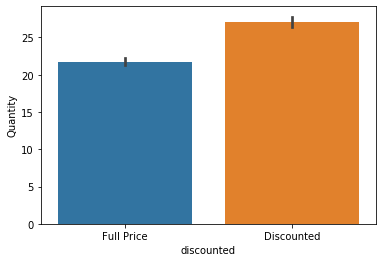

In [8]:
sns.barplot(data=h1df, x='discounted',y='Quantity',ci=68,)

### put data into dict

In [9]:
h1dict = {}
for name in h1df['discounted'].unique():
    h1dict[name] = h1df.groupby('discounted').get_group(name)['Quantity']
    
h1dict

{'Full Price': 0       12
 1       10
 2        5
 3        9
 4       40
         ..
 2147     2
 2148     2
 2151     1
 2153     4
 2154     2
 Name: Quantity, Length: 1317, dtype: int64, 'Discounted': 6       35
 7       15
 8        6
 9       15
 11      40
         ..
 2144     2
 2146     3
 2149     2
 2150     2
 2152     2
 Name: Quantity, Length: 838, dtype: int64}

## STEP 2: Do we meet the assumptions of the chosen test?

Independent t-test (2-sample)

- No significant outliers
- Normality
- Equal Variance

### 0. Check for & Remove Outliers

[Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Quantity for Full Price vs Discounted Products')]

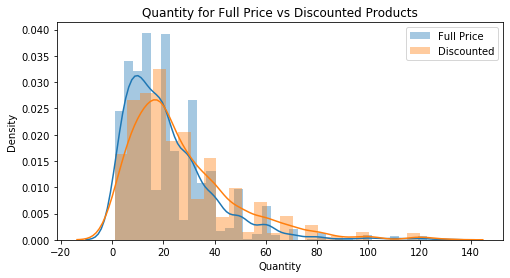

In [10]:
##Outlier Removal
fig,ax=plt.subplots(figsize=(8,4))
for name,values in h1dict.items():
    sns.distplot(values,label=name, ax=ax)
    
    
ax.legend()
ax.set(title='Quantity for Full Price vs Discounted Products', ylabel='Density')

In [11]:
for name,values in h1dict.items():
    idx_outs = find_outliers_Z(values)
    print(f"Found {idx_outs.sum()} outliers using Z-score method for {name}.")
    h1dict[name] = values[~idx_outs]
    

Found 20 outliers using Z-score method for Full Price.
Found 15 outliers using Z-score method for Discounted.


### Check result of outlier removal on plot

[Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Quantity for Full Price vs Discounted Products')]

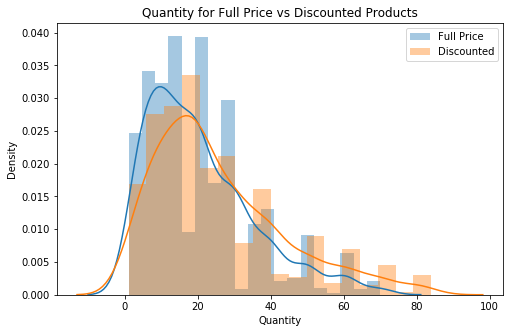

In [12]:
fig,ax=plt.subplots(figsize=(8,5))
for name,values in h1dict.items():
    sns.distplot(values,label=name, ax=ax)
    
    
ax.legend()
ax.set(title='Quantity for Full Price vs Discounted Products', ylabel='Density')

### 1. Test Assumption of Normality

In [13]:
import scipy.stats as stats

In [14]:
for key,values in h1dict.items():
    stat,p = stats.normaltest(values)
    print(f"Group {key} Normaltest p-value={round(p,4)}")
    sig = 'is NOT' if p<.05 else 'IS'

    print(f"\t-The data {sig} normal.")

Group Full Price Normaltest p-value=0.0
	-The data is NOT normal.
Group Discounted Normaltest p-value=0.0
	-The data is NOT normal.


### 1B. We don't have normal data:

In [15]:
len(h1dict['Full Price']), len(h1dict['Discounted'])

(1297, 823)

But group sizes (n) are bigger than required 15 for each group so we can safely ignore normality assumption. <br>
So we move on to equal variance assumption.

### 2. Test for Equal Variance

In [16]:
h1data = []
for key,vals in h1dict.items():
    h1data.append(vals)

In [17]:
h1data[0]

0       12
1       10
2        5
3        9
4       40
        ..
2147     2
2148     2
2151     1
2153     4
2154     2
Name: Quantity, Length: 1297, dtype: int64

In [18]:
stats.levene(h1data[0],h1data[1])

LeveneResult(statistic=19.187113832590878, pvalue=1.2429073348187694e-05)

In [19]:
stat,p = stats.levene(*h1data)
print(f"Levene's Test for Equal Variance p-value={round(p,4)}")
sig = 'do NOT' if p<.05 else 'DO'

print(f"\t-The groups {sig} have equal variance.")

Levene's Test for Equal Variance p-value=0.0
	-The groups do NOT have equal variance.


### Failed the assumption of equal variance:

Since we don't have equal variance and data is not normal, we need to use a non-parametric version of a t-test. 
 - The non-parametric version for 2 sample is Mann-Whitney U test.
 - Works from medians instead of means. 
 - scipy.stats.mannwhitneyu()

## STEP 3: Interpret Result & Post-Hoc Tests

### Perform hypothesis test from summary table above to get your p-value.

- If p value is < $\alpha$:

    - Reject the null hypothesis.
    - Calculate effect size (e.g. Cohen's $d$)
- If p<.05 AND you have multiple groups (i.e. ANOVA)

    - Must run a pairwise Tukey's test to know which groups were significantly different.
    - Tukey pairwise comparison test
    - statsmodels.stats.multicomp.pairwise_tukeyhsd
- Report statistical power (optional)

In [20]:
stat,h1p = stats.mannwhitneyu(h1data[0],h1data[1])
print(f"Mann Whitney U p-value={round(h1p,4)}")

Mann Whitney U p-value=0.0


Mann Whitney p val defaults to one-sided test, so double that p val for our two sided test, and we will reject null hypothesis. 

### Calculate effect size (e.g. Cohen's  𝑑 )

In [21]:
h1effectsize = Cohen_d(h1dict['Full Price'],h1dict['Discounted'])
h1effectsize

-0.32001140965727837

# --QUESTION!

0.3 effect size is small. What does this tell us?

### Report statistical power (optional)

statsmodels.stats.power:
TTestIndPower , TTestPower

In [22]:
from statsmodels.stats.power import TTestIndPower, TTestPower
power_analysis = TTestIndPower()

In [23]:
len(h1dict['Full Price']+h1dict['Discounted'])

2120

In [24]:
# show the power to see how well we can reject null.
power_analysis.solve_power(effect_size=h1effectsize, nobs1=2120, alpha=h1p)

0.9999327217471883

In [25]:
# power is .99 so yeah we have a solid bet of rejecting null hypothesis and not getting any type 1 errors.

## What levels of discount?

### If p<.05 AND you have multiple groups (i.e. ANOVA)

- Must run a pairwise Tukey's test to know which groups were significantly different.
- Tukey pairwise comparison test
- statsmodels.stats.multicomp.pairwise_tukeyhsd

> Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount? 

### Make dict into dataframes for tukeys

In [26]:
def prep_data_for_tukeys(data):
    """Accepts a dictionary with group names as the keys 
    and pandas series as the values. 
    
    Returns a dataframe ready for tukeys test:
    - with a 'data' column and a 'group' column for sms.stats.multicomp.pairwise_tukeyhsd 
    
    Example Use:
    df_tukey = prep_data_for_tukeys(grp_data)
    tukey = sms.stats.multicomp.pairwise_tukeyhsd(df_tukey['data'], df_tukey['group'])
    tukey.summary()
    """
    df_tukey = pd.DataFrame(columns=['data','group'])
    for k,v in  data.items():
        grp_df = v.rename('data').to_frame() 
        grp_df['group'] = k
        df_tukey=pd.concat([df_tukey, grp_df],axis=0)

	## New lines added to ensure compatibility with tukey's test
    df_tukey['group'] = df_tukey['group'].astype('str')
    df_tukey['data'] = df_tukey['data'].astype('float')
    return df_tukey


In [27]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd


# --QUESTION!

This tukeys function below and the barplot following it use my h1 dataframe before we changed it into dictionary and removed outliers, so it's using all of the data including outliers to determine the test. How should I fix this. I can't use h1dict, because that one does not contain data for the discount amounts to split into groups based on discount, which is what we need to do tukeys, not whether it was discounted or full price like in previous tests. 

In [28]:
# contains all outliers prior to outlier removal
h1tukey = pairwise_tukeyhsd(h1df['Quantity'],h1df['Discount'])
h1tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0.0,0.01,-19.7153,0.9,-80.3306,40.9001,False
0.0,0.02,-19.7153,0.9,-62.593,23.1625,False
0.0,0.03,-20.0486,0.725,-55.0714,14.9742,False
0.0,0.04,-20.7153,0.9,-81.3306,39.9001,False
0.0,0.05,6.2955,0.0011,1.5381,11.053,True
0.0,0.06,-19.7153,0.9,-80.3306,40.9001,False
0.0,0.1,3.5217,0.4269,-1.3783,8.4217,False
0.0,0.15,6.6669,0.0014,1.551,11.7828,True
0.0,0.2,5.3096,0.0303,0.2508,10.3684,True
0.0,0.25,6.525,0.0023,1.3647,11.6852,True


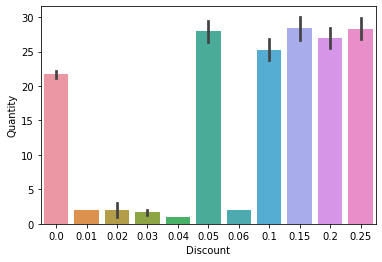

In [29]:
# contains all outliers prior to outlier removal

sns.barplot(data=h1df,x='Discount',y='Quantity',ci=68)

# Hypothesis 2

## Question

> Does discount amount have a statistically significant effect on the total spent ($) on a product in an order? If so, at what level(s) of discount?

## Null and Alternative Hypothesis

- $H_0$: Customers spend the same total amounts on both discounted and non-discounted products. 

- $H_1$: Customers spend different total amounts of money on discounted products vs full price products. 

## STEP 1: Determine the category/type of test based on your data

Type of data: numeric <br>
    How many groups compared: Two different groups if comparing discount or full price.
        - So we use 2 sample t-test

### split data into 2 groups

In [30]:
cur.execute("""SELECT Id, UnitPrice, Quantity, Discount from OrderDetail""")
col_names=[x[0] for x in cur.description]
col_names

['Id', 'UnitPrice', 'Quantity', 'Discount']

In [31]:
h2df = pd.DataFrame(cur.fetchall(), columns=col_names)
h2df

,Id,UnitPrice,Quantity,Discount
0,10248/11,14.00,12,0.00
1,10248/42,9.80,10,0.00
2,10248/72,34.80,5,0.00
3,10249/14,18.60,9,0.00
4,10249/51,42.40,40,0.00
...,...,...,...,...
2150,11077/64,33.25,2,0.03
2151,11077/66,17.00,1,0.00
2152,11077/73,15.00,2,0.01
2153,11077/75,7.75,4,0.00


In [32]:
## Create 'discounted' column for groupby 
h2df['discounted'] = h2df['Discount']>0
h2df['discounted'] = h2df['discounted'].map({True:'Discounted',False:'Full Price'})
h2df

,Id,UnitPrice,Quantity,Discount,discounted
0,10248/11,14.00,12,0.00,Full Price
1,10248/42,9.80,10,0.00,Full Price
2,10248/72,34.80,5,0.00,Full Price
3,10249/14,18.60,9,0.00,Full Price
4,10249/51,42.40,40,0.00,Full Price
...,...,...,...,...,...
2150,11077/64,33.25,2,0.03,Discounted
2151,11077/66,17.00,1,0.00,Full Price
2152,11077/73,15.00,2,0.01,Discounted
2153,11077/75,7.75,4,0.00,Full Price


In [33]:
## create total spent
h2df["Total Spent"] = h2df['UnitPrice'] * h2df['Quantity']
h2df

,Id,UnitPrice,Quantity,Discount,discounted,Total Spent
0,10248/11,14.00,12,0.00,Full Price,168.0
1,10248/42,9.80,10,0.00,Full Price,98.0
2,10248/72,34.80,5,0.00,Full Price,174.0
3,10249/14,18.60,9,0.00,Full Price,167.4
4,10249/51,42.40,40,0.00,Full Price,1696.0
...,...,...,...,...,...,...
2150,11077/64,33.25,2,0.03,Discounted,66.5
2151,11077/66,17.00,1,0.00,Full Price,17.0
2152,11077/73,15.00,2,0.01,Discounted,30.0
2153,11077/75,7.75,4,0.00,Full Price,31.0


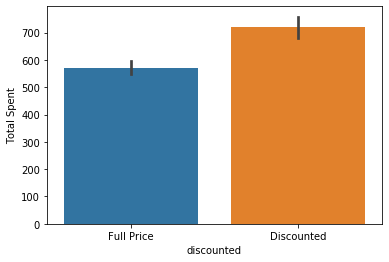

In [34]:
sns.barplot(data=h2df, x='discounted', y='Total Spent', ci=68 )

### put data into dict

In [35]:
h2dict = {}
for name in h2df['discounted'].unique():
    h2dict[name] = h2df.groupby('discounted').get_group(name)['Total Spent']
    
h2dict

{'Full Price': 0        168.0
 1         98.0
 2        174.0
 3        167.4
 4       1696.0
          ...  
 2147      14.0
 2148      48.0
 2151      17.0
 2153      31.0
 2154      26.0
 Name: Total Spent, Length: 1317, dtype: float64, 'Discounted': 6       1484.0
 7        252.0
 8        100.8
 9        234.0
 11      2592.0
          ...  
 2144      36.0
 2146      36.0
 2149      68.0
 2150      66.5
 2152      30.0
 Name: Total Spent, Length: 838, dtype: float64}

## STEP 2: Do we meet the assumptions of the chosen test?

Independent t-test (2-sample)

- No significant outliers
- Normality
- Equal Variance

### 0. Check for & Remove Outliers

[Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Total Spent on Full Price vs Discounted Products')]

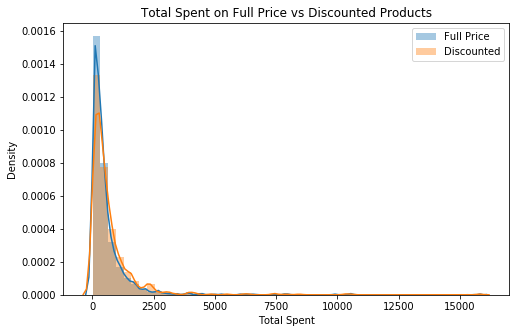

In [36]:
fig,ax=plt.subplots(figsize=(8,5))
for name,values in h2dict.items():
    sns.distplot(values,label=name, ax=ax)
    
    
ax.legend()
ax.set(title='Total Spent on Full Price vs Discounted Products', ylabel='Density')

In [37]:
for name,values in h2dict.items():
    idx_outs = find_outliers_Z(values)
    print(f"Found {idx_outs.sum()} outliers using Z-score method for {name}.")
    h2dict[name] = values[~idx_outs]
    

Found 19 outliers using Z-score method for Full Price.
Found 13 outliers using Z-score method for Discounted.


### Check result of outlier removal on plot

[Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Total Spent on Full Price vs Discounted Products')]

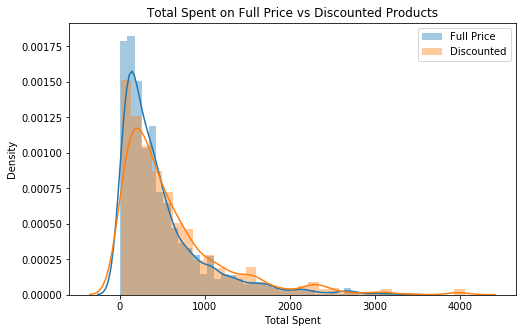

In [38]:
fig,ax=plt.subplots(figsize=(8,5))
for name,values in h2dict.items():
    sns.distplot(values,label=name, ax=ax)
    
    
ax.legend()
ax.set(title='Total Spent on Full Price vs Discounted Products', ylabel='Density')

### 1. Test Assumption of Normality

In [39]:
import scipy.stats as stats

In [40]:
for key,values in h2dict.items():
    stat,h2p = stats.normaltest(values)
    print(f"Group {key} Normaltest p-value={round(h2p,4)}")
    sig = 'is NOT' if h2p<.05 else 'IS'

    print(f"\t-The data {sig} normal.")

Group Full Price Normaltest p-value=0.0
	-The data is NOT normal.
Group Discounted Normaltest p-value=0.0
	-The data is NOT normal.


### 1B. We don't have normal data:

In [41]:
len(h2dict['Full Price']), len(h2dict['Discounted'])

(1298, 825)

But group sizes (n) are bigger than required 15 for each group so we can safely ignore normality assumption. <br>
So we move on to equal variance assumption.

### 2. Test for Equal Variance

In [42]:
# put data into lists for levene's test args
h2data = []
for key,vals in h2dict.items():
    h2data.append(vals)

In [43]:
h2data[1]

6       1484.0
7        252.0
8        100.8
9        234.0
11      2592.0
         ...  
2144      36.0
2146      36.0
2149      68.0
2150      66.5
2152      30.0
Name: Total Spent, Length: 825, dtype: float64

In [44]:
stat,h2p = stats.levene(*h2data)
print(f"Levene's Test for Equal Variance p-value={round(h2p,4)}")
sig = 'do NOT' if h2p<.05 else 'DO'

print(f"\t-The groups {sig} have equal variance.")

Levene's Test for Equal Variance p-value=0.0
	-The groups do NOT have equal variance.


### Failed the assumption of equal variance:

Since we don't have equal variance and data is not normal, we need to use a non-parametric version of a t-test. 
 - The non-parametric version for 2 sample is Mann-Whitney U test.
 - Works from medians instead of means. 
 - scipy.stats.mannwhitneyu()

## STEP 3: Interpret Result & Post-Hoc Tests

### Perform hypothesis test from summary table above to get your p-value.

- If p value is < $\alpha$:

    - Reject the null hypothesis.
    - Calculate effect size (e.g. Cohen's $d$)
- If p<.05 AND you have multiple groups (i.e. ANOVA)

    - Must run a pairwise Tukey's test to know which groups were significantly different.
    - Tukey pairwise comparison test
    - statsmodels.stats.multicomp.pairwise_tukeyhsd
- Report statistical power (optional)

In [45]:
stat,h2p = stats.mannwhitneyu(h2data[0],h2data[1])
print(f"Mann Whitney U p-value={round(h2p,4)}")

Mann Whitney U p-value=0.0


Mann Whitney p val defaults to one-sided test, so double that p val for our two sided test, and we will reject null hypothesis. 

### Calculate effect size (e.g. Cohen's  𝑑 )

In [46]:
h2effectsize = Cohen_d(h2dict['Full Price'],h2dict['Discounted'])
h2effectsize

-0.22821293413002144

# --QUESTION!

0.2 effect size is small. What does this tell us?

### Report statistical power (optional)

statsmodels.stats.power:
TTestIndPower , TTestPower

In [47]:
len(h2dict['Full Price']+h2dict['Discounted'])

2123

In [48]:
# show the power to see how well we can reject null.
power_analysis.solve_power(effect_size=h2effectsize, nobs1=2123, alpha=h2p)

0.9882912139030121

In [49]:
# power is .99 so yeah we have a solid bet of rejecting null hypothesis and not getting any type 1 errors.

## What levels of discount?

### If p<.05 AND you have multiple groups (i.e. ANOVA)

- Must run a pairwise Tukey's test to know which groups were significantly different.
- Tukey pairwise comparison test
- statsmodels.stats.multicomp.pairwise_tukeyhsd

> Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount? 

### Make dict into dataframes for tukeys

# --QUESTION!

This tukeys function below and the barplot following it use my h2 dataframe before we changed it into dictionary and removed outliers, so it's using all of the data including outliers to determine the test. How should I fix this. I can't use h1dict, because that one does not contain data for the discount amounts to split into groups based on discount, which is what we need to do tukeys, not whether it was discounted or full price like in previous tests. 

In [50]:
h2df

,Id,UnitPrice,Quantity,Discount,discounted,Total Spent
0,10248/11,14.00,12,0.00,Full Price,168.0
1,10248/42,9.80,10,0.00,Full Price,98.0
2,10248/72,34.80,5,0.00,Full Price,174.0
3,10249/14,18.60,9,0.00,Full Price,167.4
4,10249/51,42.40,40,0.00,Full Price,1696.0
...,...,...,...,...,...,...
2150,11077/64,33.25,2,0.03,Discounted,66.5
2151,11077/66,17.00,1,0.00,Full Price,17.0
2152,11077/73,15.00,2,0.01,Discounted,30.0
2153,11077/75,7.75,4,0.00,Full Price,31.0


In [104]:
def data_for_tukeys(data):
    """Accepts a dictionary with group names as the keys 
    and pandas series as the values. 
    Returns a dataframe ready for tukeys test:
    - with a 'data' column and a 'group' column for sms.stats.multicomp.pairwise_tukeyhsd 
    Example Use:
    df_tukey = prep_data_for_tukeys(grp_data)
    tukey = sms.stats.multicomp.pairwise_tukeyhsd(df_tukey['data'], df_tukey['group'])
    tukey.summary()
    """
    df_tukey = pd.DataFrame(columns=['data','group'])
    for k,v in  data.items():
        grp_df = v.rename('data').to_frame() 
        grp_df['group'] = k
        df_tukey=pd.concat([df_tukey, grp_df],axis=0)

    ## New lines added to ensure compatibility with tukey's test
    df_tukey['group'] = df_tukey['group'].astype('str')
    df_tukey['data'] = df_tukey['data'].astype('float')
    return df_tukey

In [ ]:
data_for_tukeys(h2dict)

In [51]:
# contains all outliers prior to outlier removal
h2tukey = pairwise_tukeyhsd(h2df['Total Spent'],h2df['Discount'])
h2tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0.0,0.01,-540.0065,0.9,-3870.951,2790.9379,False
0.0,0.02,-539.5065,0.9,-2895.7333,1816.7202,False
0.0,0.03,-528.4565,0.9,-2453.0368,1396.1237,False
0.0,0.04,-489.0065,0.9,-3819.951,2841.9379,False
0.0,0.05,269.9216,0.0362,8.4896,531.3536,True
0.0,0.06,-502.0065,0.9,-3832.951,2828.9379,False
0.0,0.1,17.6565,0.9,-251.6084,286.9214,False
0.0,0.15,85.716,0.9,-195.4149,366.8469,False
0.0,0.2,122.3933,0.9,-155.5997,400.3864,False
0.0,0.25,286.6044,0.045,3.0375,570.1714,True


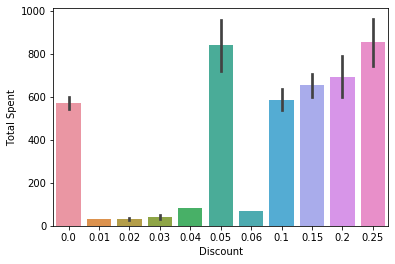

In [52]:
# contains all outliers prior to outlier removal

sns.barplot(data=h2df,x='Discount',y='Total Spent',ci=68)

# Hypothesis 3

## Question

> Does supplier region have a statistically significant effect on the average total spent per sale? If so, which region(s)?

## Null and Alternative Hypothesis

- $H_0$: Supplier region does not have a significant effect on total supplier sales. 

- $H_1$: Supplier region does have a significant effect on total supplier sales.

## STEP 1: Determine the category/type of test based on your data

Type of data: Numerical <br>
    How many groups compared: There are 11 different regions/groups to compare.
    - So we'll use ANOVA & Tukey tests since there are more than two groups. 

### Put data in df

In [53]:
cur.execute("""SELECT *
                FROM Product
                """)
col_names=[x[0] for x in cur.description]
col_names

['Id',
 'ProductName',
 'SupplierId',
 'CategoryId',
 'QuantityPerUnit',
 'UnitPrice',
 'UnitsInStock',
 'UnitsOnOrder',
 'ReorderLevel',
 'Discontinued']

In [54]:
cur.execute("""SELECT *
                FROM OrderDetail
                """)
col_names=[x[0] for x in cur.description]
col_names

['Id', 'OrderId', 'ProductId', 'UnitPrice', 'Quantity', 'Discount']

In [55]:
cur.execute("""SELECT *
                FROM Supplier
                """)
col_names=[x[0] for x in cur.description]
col_names

['Id',
 'CompanyName',
 'ContactName',
 'ContactTitle',
 'Address',
 'City',
 'Region',
 'PostalCode',
 'Country',
 'Phone',
 'Fax',
 'HomePage']

In [56]:
cur.execute("""SELECT od.ID, od.UnitPrice, od.Quantity, s.Region
                FROM OrderDetail od
                JOIN Product p ON od.ProductID = p.ID
                JOIN Supplier s ON p.SupplierID = s.ID
                
            """)
col_names=[x[0] for x in cur.description]
col_names

['Id', 'UnitPrice', 'Quantity', 'Region']

In [57]:
h3df = pd.DataFrame(cur.fetchall(), columns=col_names)
h3df

,Id,UnitPrice,Quantity,Region
0,10248/11,14.00,12,Southern Europe
1,10248/42,9.80,10,South-East Asia
2,10248/72,34.80,5,Southern Europe
3,10249/14,18.60,9,Eastern Asia
4,10249/51,42.40,40,NSW
...,...,...,...,...
2150,11077/64,33.25,2,Western Europe
2151,11077/66,17.00,1,North America
2152,11077/73,15.00,2,Northern Europe
2153,11077/75,7.75,4,Western Europe


In [58]:
h3df['Region'].unique()

array(['Southern Europe', 'South-East Asia', 'Eastern Asia', 'NSW',
       'North America', 'Northern Europe', 'British Isles', 'Scandinavia',
       'Western Europe', 'South America', 'Victoria'], dtype=object)

In [59]:
## create total spent
h3df["Total Spent"] = h3df['UnitPrice'] * h3df['Quantity']
h3df

,Id,UnitPrice,Quantity,Region,Total Spent
0,10248/11,14.00,12,Southern Europe,168.0
1,10248/42,9.80,10,South-East Asia,98.0
2,10248/72,34.80,5,Southern Europe,174.0
3,10249/14,18.60,9,Eastern Asia,167.4
4,10249/51,42.40,40,NSW,1696.0
...,...,...,...,...,...
2150,11077/64,33.25,2,Western Europe,66.5
2151,11077/66,17.00,1,North America,17.0
2152,11077/73,15.00,2,Northern Europe,30.0
2153,11077/75,7.75,4,Western Europe,31.0


# --QUESTION! - need to make region names legible

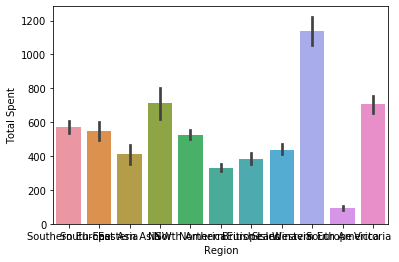

In [60]:
sns.barplot(data=h3df, x='Region', y='Total Spent', ci=68)

### put data into dict

In [61]:
h3dict = {}
for name in h3df['Region'].unique():
    h3dict[name] = h3df.groupby('Region').get_group(name)['Total Spent']
    
h3dict

{'Southern Europe': 0       168.0
 2       174.0
 9       234.0
 14      200.0
 31      153.6
         ...  
 2077    390.0
 2114    250.0
 2121    210.0
 2137     76.0
 2143     32.0
 Name: Total Spent, Length: 229, dtype: float64,
 'South-East Asia': 1         98.00
 60       920.00
 78       248.00
 96       325.50
 116      372.00
          ...   
 2032     233.40
 2036     420.00
 2051     291.75
 2067    1380.00
 2108    1656.00
 Name: Total Spent, Length: 82, dtype: float64,
 'Eastern Asia': 3       167.40
 19      168.00
 46      288.00
 65      595.20
 74      372.00
          ...  
 2116     60.00
 2128    465.00
 2136     31.00
 2138     24.00
 2139     23.25
 Name: Total Spent, Length: 119, dtype: float64,
 'NSW': 4       1696.0
 6       1484.0
 24       393.0
 101      943.2
 117       84.8
          ...  
 2056    1272.0
 2076    1060.0
 2091     328.0
 2098     820.0
 2147      14.0
 Name: Total Spent, Length: 98, dtype: float64,
 'North America': 5         77.00
 7     

## STEP 2: Do we meet the assumptions of the chosen test?

ANOVA tukey

- No significant outliers
- Normality
- Equal Variance

### 0. Check for & Remove Outliers

[Text(0, 0.5, 'Density'), Text(0.5, 1.0, 'Total Spent by Region')]

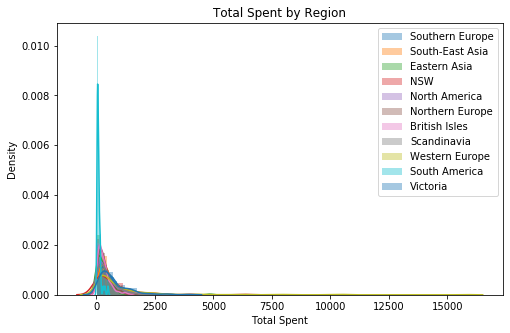

In [62]:
fig,ax=plt.subplots(figsize=(8,5))
for name,values in h3dict.items():
    sns.distplot(values,label=name, ax=ax)
    
    
ax.legend()
ax.set(title='Total Spent by Region', ylabel='Density')

Something is seriously skewing the sales data for these regions. Looks like Western Europe and South America. 

In [63]:
h3df.describe()

,UnitPrice,Quantity,Total Spent
count,2155.000000,2155.000000,2155.000000
mean,26.218520,23.812993,628.519067
std,29.827418,19.022047,1036.466980
min,2.000000,1.000000,4.800000
25%,12.000000,10.000000,154.000000
50%,18.400000,20.000000,360.000000
75%,32.000000,30.000000,722.250000
max,263.500000,130.000000,15810.000000


In [64]:
for name,values in h3dict.items():
    idx_outs = find_outliers_Z(values)
    print(f"Found {idx_outs.sum()} outliers using Z-score method for {name}.")
    h3dict[name] = values[~idx_outs]
    

Found 6 outliers using Z-score method for Southern Europe.
Found 1 outliers using Z-score method for South-East Asia.
Found 2 outliers using Z-score method for Eastern Asia.
Found 2 outliers using Z-score method for NSW.
Found 11 outliers using Z-score method for North America.
Found 2 outliers using Z-score method for Northern Europe.
Found 4 outliers using Z-score method for British Isles.
Found 2 outliers using Z-score method for Scandinavia.
Found 13 outliers using Z-score method for Western Europe.
Found 2 outliers using Z-score method for South America.
Found 4 outliers using Z-score method for Victoria.


### 1. Test Assumption of Normality

In [65]:
for key,values in h3dict.items():
    stat,h3p = stats.normaltest(values)
    print(f"Group {key} Normaltest p-value={round(h3p,4)}")
    sig = 'is NOT' if h3p<.05 else 'IS'

    print(f"\t-The data {sig} normal.")

Group Southern Europe Normaltest p-value=0.0
	-The data is NOT normal.
Group South-East Asia Normaltest p-value=0.0001
	-The data is NOT normal.
Group Eastern Asia Normaltest p-value=0.0
	-The data is NOT normal.
Group NSW Normaltest p-value=0.0
	-The data is NOT normal.
Group North America Normaltest p-value=0.0
	-The data is NOT normal.
Group Northern Europe Normaltest p-value=0.0
	-The data is NOT normal.
Group British Isles Normaltest p-value=0.0
	-The data is NOT normal.
Group Scandinavia Normaltest p-value=0.0
	-The data is NOT normal.
Group Western Europe Normaltest p-value=0.0
	-The data is NOT normal.
Group South America Normaltest p-value=0.0
	-The data is NOT normal.
Group Victoria Normaltest p-value=0.0
	-The data is NOT normal.


### 1B. We don't have normal data:

So in order to ignore non-normality, if we have 2-9 groups, each group needs n >= 15.
If we have 10-12 groups, we need each group to have n>20. We have 11 groups. 

In [66]:
for name in h3dict.keys():
    region = name
    print(f"{region}: ", len(h3dict[name]))

Southern Europe:  223
South-East Asia:  81
Eastern Asia:  117
NSW:  96
North America:  407
Northern Europe:  151
British Isles:  216
Scandinavia:  173
Western Europe:  434
South America:  49
Victoria:  159


All 11 group sizes (n) are bigger than required 20 for each group so we can safely ignore normality assumption. <br>
So we move on to equal variance assumption.

### 2. Test for Equal Variance

In [67]:
# put data into lists for levene's test args
h3data = []
for key,vals in h3dict.items():
    h3data.append(vals)

In [68]:
h3data[1]

1         98.00
60       920.00
78       248.00
96       325.50
116      372.00
         ...   
2032     233.40
2036     420.00
2051     291.75
2067    1380.00
2108    1656.00
Name: Total Spent, Length: 81, dtype: float64

In [69]:
stat,h3p = stats.levene(*h3data)
print(f"Levene's Test for Equal Variance p-value={round(h3p,4)}")
sig = 'do NOT' if h3p<.05 else 'DO'

print(f"\t-The groups {sig} have equal variance.")

Levene's Test for Equal Variance p-value=0.0
	-The groups do NOT have equal variance.


### Failed the assumption of equal variance:

Since we don't have equal variance and data is not normal, we need to use a non-parametric version of a t-test. 
 - The non-parametric version for ANOVA is Kruskal-Wallis.
 - Works from medians instead of means. 
 - scipy.stats.kruskal

## STEP 3: Interpret Result & Post-Hoc Tests

### Perform hypothesis test from summary table above to get your p-value.

- If p value is < $\alpha$:

    - Reject the null hypothesis.
    - Calculate effect size (e.g. Cohen's $d$)
- If p<.05 AND you have multiple groups (i.e. ANOVA)

    - Must run a pairwise Tukey's test to know which groups were significantly different.
    - Tukey pairwise comparison test
    - statsmodels.stats.multicomp.pairwise_tukeyhsd
- Report statistical power (optional)

In [70]:
stat,h3p = stats.kruskal(*h3data)
print(f"Kruskal-Wallis p-value={round(h3p,4)}")

Kruskal-Wallis p-value=0.0


Kruskal-Wallis p val shows that the null hypothesis should be rejected but need to check with a tukeys test to see which groups specifically are significant. 

### Checking Tukeys for specific group significance.

### If p<.05 AND you have multiple groups (i.e. ANOVA)

- Must run a pairwise Tukey's test to know which groups were significantly different.
- Tukey pairwise comparison test
- statsmodels.stats.multicomp.pairwise_tukeyhsd

> Does supplier region have a statistically significant effect on the total sales of the supplier? If so, which region(s)?

# --QUESTION!

This tukeys function below and the barplot following it use my h3 dataframe before we changed it into dictionary and removed outliers, so it's using all of the data including outliers to determine the test. How should I fix this. I can't use h1dict, because that one does not contain data for the discount amounts to split into groups based on discount, which is what we need to do tukeys, not whether it was discounted or full price like in previous tests. 

In [71]:
h3df

,Id,UnitPrice,Quantity,Region,Total Spent
0,10248/11,14.00,12,Southern Europe,168.0
1,10248/42,9.80,10,South-East Asia,98.0
2,10248/72,34.80,5,Southern Europe,174.0
3,10249/14,18.60,9,Eastern Asia,167.4
4,10249/51,42.40,40,NSW,1696.0
...,...,...,...,...,...
2150,11077/64,33.25,2,Western Europe,66.5
2151,11077/66,17.00,1,North America,17.0
2152,11077/73,15.00,2,Northern Europe,30.0
2153,11077/75,7.75,4,Western Europe,31.0


In [107]:
h3tukeydata = data_for_tukeys(h3dict)
h3tukeydata

,data,group
0,168.00,Southern Europe
2,174.00,Southern Europe
9,234.00,Southern Europe
14,200.00,Southern Europe
31,153.60,Southern Europe
...,...,...
2092,180.00,Victoria
2103,52.35,Victoria
2113,523.50,Victoria
2123,244.30,Victoria


In [108]:
# contains all outliers prior to outlier removal
h3tukey = pairwise_tukeyhsd(h3tukeydata['data'],h3tukeydata['group'])
h3tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
British Isles,Eastern Asia,14.655,0.9,-207.9509,237.2609,False
British Isles,NSW,280.1238,0.0071,42.2486,517.999,True
British Isles,North America,128.9323,0.2793,-34.3181,292.1827,False
British Isles,Northern Europe,-20.4693,0.9,-226.1777,185.2391,False
British Isles,Scandinavia,81.4215,0.9,-116.4391,279.282,False
British Isles,South America,-257.8523,0.1968,-564.7067,49.0021,False
British Isles,South-East Asia,182.6815,0.4172,-69.9824,435.3454,False
British Isles,Southern Europe,179.2675,0.068,-5.867,364.402,False
British Isles,Victoria,306.9615,0.001,104.3218,509.6012,True
British Isles,Western Europe,531.6876,0.001,370.2074,693.1678,True


In [109]:
df = pd.DataFrame(data=h3tukey._results_table.data[1:], columns=h3tukey._results_table.data[0])
df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,British Isles,Eastern Asia,14.6550,0.9000,-207.9509,237.2609,False
1,British Isles,NSW,280.1238,0.0071,42.2486,517.9990,True
2,British Isles,North America,128.9323,0.2793,-34.3181,292.1827,False
3,British Isles,Northern Europe,-20.4693,0.9000,-226.1777,185.2391,False
4,British Isles,Scandinavia,81.4215,0.9000,-116.4391,279.2820,False
5,British Isles,South America,-257.8523,0.1968,-564.7067,49.0021,False
6,British Isles,South-East Asia,182.6815,0.4172,-69.9824,435.3454,False
7,British Isles,Southern Europe,179.2675,0.0680,-5.8670,364.4020,False
8,British Isles,Victoria,306.9615,0.0010,104.3218,509.6012,True
9,British Isles,Western Europe,531.6876,0.0010,370.2074,693.1678,True


In [111]:
df.loc[df['reject']==True]

,group1,group2,meandiff,p-adj,lower,upper,reject
1,British Isles,NSW,280.1238,0.0071,42.2486,517.9990,True
8,British Isles,Victoria,306.9615,0.0010,104.3218,509.6012,True
9,British Isles,Western Europe,531.6876,0.0010,370.2074,693.1678,True
17,Eastern Asia,Victoria,292.3065,0.0033,56.0970,528.5160,True
18,Eastern Asia,Western Europe,517.0326,0.0010,315.0229,719.0424,True
20,NSW,Northern Europe,-300.5932,0.0063,-553.7320,-47.4544,True
22,NSW,South America,-537.9761,0.0010,-878.4507,-197.5016,True
26,NSW,Western Europe,251.5638,0.0098,32.8421,470.2854,True
29,North America,South America,-386.7846,0.0011,-680.0234,-93.5457,True
33,North America,Western Europe,402.7553,0.0010,268.9448,536.5659,True


[Text(0, 0, 'Southern Europe'),
 Text(0, 0, 'South-East Asia'),
 Text(0, 0, 'Eastern Asia'),
 Text(0, 0, 'NSW'),
 Text(0, 0, 'North America'),
 Text(0, 0, 'Northern Europe'),
 Text(0, 0, 'British Isles'),
 Text(0, 0, 'Scandinavia'),
 Text(0, 0, 'Western Europe'),
 Text(0, 0, 'South America'),
 Text(0, 0, 'Victoria')]

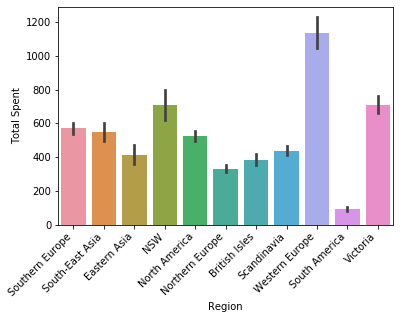

In [103]:
# contains all outliers prior to outlier removal

ax = sns.barplot(data=h3df,x='Region',y='Total Spent',ci=68)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')



### Calculate effect size (e.g. Cohen's  𝑑 )

# --QUESTION! 

Not sure how to do cohens for this hypothesis since I'm looking at 11 different groups based on region. 

In [74]:
# h3effectsize = Cohen_d(h3dict['Full Price'],h3dict['Discounted'])
# h3effectsize

### Report statistical power (optional)

# --CAN'T DO until get effect size

statsmodels.stats.power:
TTestIndPower , TTestPower

In [75]:
# len(h3dict['Full Price']+h3dict['Discounted'])

In [76]:
# # show the power to see how well we can reject null.
# power_analysis.solve_power(effect_size=h3effectsize, nobs1=2123, alpha=h3p)

# Hypothesis 4

## Question

> Does employee have a statistically significant effect on the total spent ($) on a product in an order? If so, which employees(s)?

## Null and Alternative Hypothesis

- $H_0$: Employees do not have a significant effect on total spent on a product in an order. 

- $H_1$: Employees do have a significant effect on total spent on a product in an order.

## STEP 1: Determine the category/type of test based on your data

Type of data: Numerical <br>
    How many groups compared: There are 9 different employees/groups to compare.
    - So we'll use ANOVA & Tukey tests since there are more than two groups. 

### Put data in df

In [77]:
cur.execute("""SELECT *
                FROM OrderDetail
                """)
col_names=[x[0] for x in cur.description]
col_names

['Id', 'OrderId', 'ProductId', 'UnitPrice', 'Quantity', 'Discount']

In [78]:
cur.execute("""SELECT *
                FROM `Order`
                """)
col_names=[x[0] for x in cur.description]
col_names

['Id',
 'CustomerId',
 'EmployeeId',
 'OrderDate',
 'RequiredDate',
 'ShippedDate',
 'ShipVia',
 'Freight',
 'ShipName',
 'ShipAddress',
 'ShipCity',
 'ShipRegion',
 'ShipPostalCode',
 'ShipCountry']

In [79]:
cur.execute("""SELECT *
                FROM Employee
                """)
col_names=[x[0] for x in cur.description]
col_names

['Id',
 'LastName',
 'FirstName',
 'Title',
 'TitleOfCourtesy',
 'BirthDate',
 'HireDate',
 'Address',
 'City',
 'Region',
 'PostalCode',
 'Country',
 'HomePhone',
 'Extension',
 'Photo',
 'Notes',
 'ReportsTo',
 'PhotoPath']

In [80]:
cur.execute("""SELECT od.OrderId, od.UnitPrice, od.Quantity, e.Id, e.LastName, e.FirstName
                FROM OrderDetail od
                JOIN `Order` o ON od.OrderId = o.Id                
                JOIN Employee e ON o.EmployeeId = e.Id                
""")
col_names=[x[0] for x in cur.description]
col_names

['OrderId', 'UnitPrice', 'Quantity', 'Id', 'LastName', 'FirstName']

In [81]:
h4df = pd.DataFrame(cur.fetchall(), columns=col_names)
h4df

,OrderId,UnitPrice,Quantity,Id,LastName,FirstName
0,10248,14.00,12,5,Buchanan,Steven
1,10248,9.80,10,5,Buchanan,Steven
2,10248,34.80,5,5,Buchanan,Steven
3,10249,18.60,9,6,Suyama,Michael
4,10249,42.40,40,6,Suyama,Michael
...,...,...,...,...,...,...
2150,11077,33.25,2,1,Davolio,Nancy
2151,11077,17.00,1,1,Davolio,Nancy
2152,11077,15.00,2,1,Davolio,Nancy
2153,11077,7.75,4,1,Davolio,Nancy


In [82]:
# we have same number of unique first and last names so there are no people with same last name that could 
# be accidentally grouped as one person. 
h4df['FirstName'].nunique()

9

In [83]:
h4df['LastName'].nunique()

9

In [84]:
## create total spent
h4df["Total Spent"] = h4df['UnitPrice'] * h4df['Quantity']
h4df

,OrderId,UnitPrice,Quantity,Id,LastName,FirstName,Total Spent
0,10248,14.00,12,5,Buchanan,Steven,168.0
1,10248,9.80,10,5,Buchanan,Steven,98.0
2,10248,34.80,5,5,Buchanan,Steven,174.0
3,10249,18.60,9,6,Suyama,Michael,167.4
4,10249,42.40,40,6,Suyama,Michael,1696.0
...,...,...,...,...,...,...,...
2150,11077,33.25,2,1,Davolio,Nancy,66.5
2151,11077,17.00,1,1,Davolio,Nancy,17.0
2152,11077,15.00,2,1,Davolio,Nancy,30.0
2153,11077,7.75,4,1,Davolio,Nancy,31.0


# --QUESTION! - need to make region names legible

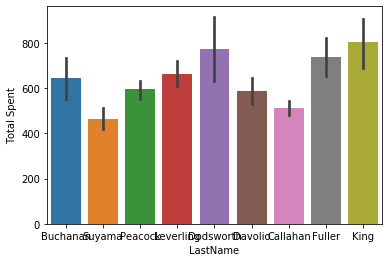

In [85]:
sns.barplot(data=h4df, x='LastName', y='Total Spent', ci=68)

### put data into dict

In [86]:
h4dict = {}
for name in h4df['LastName'].unique():
    h4dict[name] = h4df.groupby('LastName').get_group(name)['Total Spent']
    
h4dict

{'Buchanan': 0       168.0
 1        98.0
 2       174.0
 17       54.0
 18      403.2
         ...  
 1829    488.6
 1830    312.5
 1831    285.0
 1832    816.0
 2053    210.0
 Name: Total Spent, Length: 117, dtype: float64, 'Suyama': 3        167.4
 4       1696.0
 47       532.0
 48       192.5
 61        48.0
          ...  
 2023      94.5
 2024     665.0
 2025     344.0
 2055      37.5
 2056    1272.0
 Name: Total Spent, Length: 168, dtype: float64, 'Peacock': 5         77.0
 6       1484.0
 7        252.0
 11      2592.0
 12        50.0
          ...  
 2119     357.5
 2120    4322.5
 2127     500.0
 2128     465.0
 2129      92.0
 Name: Total Spent, Length: 420, dtype: float64, 'Leverling': 8       100.8
 9       234.0
 10      336.0
 14      200.0
 15      604.8
         ...  
 2068    285.0
 2081     45.0
 2093    420.0
 2094    736.0
 2095    289.5
 Name: Total Spent, Length: 321, dtype: float64, 'Dodsworth': 20       304.0
 21       486.5
 22       380.0
 23      1320.0
 43

## STEP 2: Do we meet the assumptions of the chosen test?

ANOVA tukey

- No significant outliers
- Normality
- Equal Variance

### 0. Check for & Remove Outliers

[Text(0, 0.5, 'Density'), Text(0.5, 1.0, 'Total Spent from Sale by Employee')]

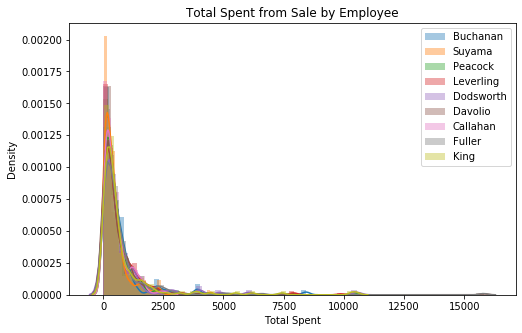

In [87]:
fig,ax=plt.subplots(figsize=(8,5))
for name,values in h4dict.items():
    sns.distplot(values,label=name, ax=ax)
    
    
ax.legend()
ax.set(title='Total Spent from Sale by Employee', ylabel='Density')

Looks like there are some outliers.  

In [88]:
for name,values in h4dict.items():
    idx_outs = find_outliers_Z(values)
    print(f"Found {idx_outs.sum()} outliers using Z-score method for {name}.")
    h4dict[name] = values[~idx_outs]
    

Found 3 outliers using Z-score method for Buchanan.
Found 4 outliers using Z-score method for Suyama.
Found 6 outliers using Z-score method for Peacock.
Found 4 outliers using Z-score method for Leverling.
Found 2 outliers using Z-score method for Dodsworth.
Found 4 outliers using Z-score method for Davolio.
Found 4 outliers using Z-score method for Callahan.
Found 5 outliers using Z-score method for Fuller.
Found 5 outliers using Z-score method for King.


### 1. Test Assumption of Normality

In [89]:
for key,values in h4dict.items():
    stat,h4p = stats.normaltest(values)
    print(f"Group {key} Normaltest p-value={round(h4p,4)}")
    sig = 'is NOT' if h4p<.05 else 'IS'

    print(f"\t-The data {sig} normal.")

Group Buchanan Normaltest p-value=0.0
	-The data is NOT normal.
Group Suyama Normaltest p-value=0.0
	-The data is NOT normal.
Group Peacock Normaltest p-value=0.0
	-The data is NOT normal.
Group Leverling Normaltest p-value=0.0
	-The data is NOT normal.
Group Dodsworth Normaltest p-value=0.0
	-The data is NOT normal.
Group Davolio Normaltest p-value=0.0
	-The data is NOT normal.
Group Callahan Normaltest p-value=0.0
	-The data is NOT normal.
Group Fuller Normaltest p-value=0.0
	-The data is NOT normal.
Group King Normaltest p-value=0.0
	-The data is NOT normal.


### 1B. We don't have normal data:

So in order to ignore non-normality, if we have 2-9 groups, each group needs n >= 15.
If we have 10-12 groups, we need each group to have n>20. We have 9 groups. 

In [90]:
for name in h4dict.keys():
    region = name
    print(f"{region}: ", len(h4dict[name]))

Buchanan:  114
Suyama:  164
Peacock:  414
Leverling:  317
Dodsworth:  105
Davolio:  341
Callahan:  256
Fuller:  236
King:  171


All 9 group sizes (n) are bigger than required 20 for each group so we can safely ignore normality assumption. <br>
So we move on to equal variance assumption.

### 2. Test for Equal Variance

In [91]:
# put data into lists for levene's test args
h4data = []
for key,vals in h4dict.items():
    h4data.append(vals)

In [92]:
h4data[1]

3        167.4
4       1696.0
47       532.0
48       192.5
61        48.0
         ...  
2023      94.5
2024     665.0
2025     344.0
2055      37.5
2056    1272.0
Name: Total Spent, Length: 164, dtype: float64

In [93]:
stat,h4p = stats.levene(*h4data)
print(f"Levene's Test for Equal Variance p-value={round(h4p,4)}")
sig = 'do NOT' if h4p<.05 else 'DO'

print(f"\t-The groups {sig} have equal variance.")

Levene's Test for Equal Variance p-value=0.0085
	-The groups do NOT have equal variance.


### Failed the assumption of equal variance:

Since we don't have equal variance and data is not normal, we need to use a non-parametric version of a t-test. 
 - The non-parametric version for ANOVA is Kruskal-Wallis.
 - Works from medians instead of means. 
 - scipy.stats.kruskal

## STEP 3: Interpret Result & Post-Hoc Tests

### Perform hypothesis test from summary table above to get your p-value.

- If p value is < $\alpha$:

    - Reject the null hypothesis.
    - Calculate effect size (e.g. Cohen's $d$)
- If p<.05 AND you have multiple groups (i.e. ANOVA)

    - Must run a pairwise Tukey's test to know which groups were significantly different.
    - Tukey pairwise comparison test
    - statsmodels.stats.multicomp.pairwise_tukeyhsd
- Report statistical power (optional)

In [94]:
stat,h4p = stats.kruskal(*h4data)
print(f"Kruskal-Wallis p-value={round(h4p,4)}")

Kruskal-Wallis p-value=0.2356


Kruskal-Wallis p val shows that the null hypothesis should be rejected but need to check with a tukeys test to see which groups specifically are significant. 

### Checking Tukeys for specific group significance.

### If p<.05 AND you have multiple groups (i.e. ANOVA)

- Must run a pairwise Tukey's test to know which groups were significantly different.
- Tukey pairwise comparison test
- statsmodels.stats.multicomp.pairwise_tukeyhsd

> Does employee have a statistically significant effect on the total spent ($) on a product in an order? If so, which employees(s)?

# --QUESTION!

This tukeys function below and the barplot following it use my h3 dataframe before we changed it into dictionary and removed outliers, so it's using all of the data including outliers to determine the test. How should I fix this. I can't use h1dict, because that one does not contain data for the discount amounts to split into groups based on discount, which is what we need to do tukeys, not whether it was discounted or full price like in previous tests. 

In [95]:
h4df

,OrderId,UnitPrice,Quantity,Id,LastName,FirstName,Total Spent
0,10248,14.00,12,5,Buchanan,Steven,168.0
1,10248,9.80,10,5,Buchanan,Steven,98.0
2,10248,34.80,5,5,Buchanan,Steven,174.0
3,10249,18.60,9,6,Suyama,Michael,167.4
4,10249,42.40,40,6,Suyama,Michael,1696.0
...,...,...,...,...,...,...,...
2150,11077,33.25,2,1,Davolio,Nancy,66.5
2151,11077,17.00,1,1,Davolio,Nancy,17.0
2152,11077,15.00,2,1,Davolio,Nancy,30.0
2153,11077,7.75,4,1,Davolio,Nancy,31.0


In [96]:
# contains all outliers prior to outlier removal
h4tukey = pairwise_tukeyhsd(h4df['Total Spent'],h4df['LastName'])
h4tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Buchanan,Callahan,-133.1819,0.9,-490.5546,224.1908,False
Buchanan,Davolio,-59.9544,0.9,-403.3928,283.4839,False
Buchanan,Dodsworth,129.4863,0.9,-299.9211,558.8936,False
Buchanan,Fuller,91.6706,0.9,-270.0476,453.3888,False
Buchanan,King,156.9399,0.9,-225.9861,539.8659,False
Buchanan,Leverling,17.833,0.9,-328.8415,364.5075,False
Buchanan,Peacock,-50.1938,0.9,-385.7767,285.3891,False
Buchanan,Suyama,-180.4133,0.871,-566.9628,206.1362,False
Callahan,Davolio,73.2275,0.9,-190.4127,336.8678,False
Callahan,Dodsworth,262.6682,0.4006,-106.0416,631.3781,False


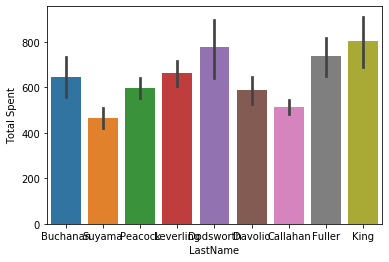

In [97]:
# contains all outliers prior to outlier removal

sns.barplot(data=h4df,x='LastName',y='Total Spent',ci=68)

### Calculate effect size (e.g. Cohen's  𝑑 )

# --QUESTION! 

Not sure how to do cohens for this hypothesis since I'm looking at 9 different groups based on region. 

In [98]:
# h4effectsize = Cohen_d(h4dict['Full Price'],h4dict['Discounted'])
# h4effectsize

### Report statistical power (optional)

# --CAN'T DO until get effect size

statsmodels.stats.power:
TTestIndPower , TTestPower

In [99]:
# len(h4dict['Full Price']+h4dict['Discounted'])

In [100]:
# # show the power to see how well we can reject null.
# power_analysis.solve_power(effect_size=h4effectsize, nobs1=2123, alpha=h4p)